# 気象庁が公開している地震データを解析する

例えば、過去の地震データは  
https://www.data.jma.go.jp/svd/eqev/data/bulletin/shindo.html  
に公開されている。

ここでは、それをダウンロードし、ファイル内容を解析して、震源地のマップやマグニチュードごとの頻度をプロットすることを目指す。

In [ ]:
import os  # ファイルのダウンロードに用いる
import zipfile  # Zipファイルの解凍に用いる
import datetime  # 日時データを取り扱うために用いる

import numpy as np
import matplotlib.pyplot as plt

## データの例

2019年の地震データは以下のURLに公開されている。ダウンロードして、どのようなファイル構成になっているか見てみよう

https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/shindo/i2019.zip

In [ ]:
url = 'https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/shindo/i2019.zip'

In [ ]:
# ファイルをダウンロードするコマンド（Windowsでは使えないかもしれない…）
os.system('wget ' + url)  # download the file into i2019.zip

0

In [ ]:
# ダウンロードしたZipファイルを展開する
with zipfile.ZipFile('i2019.zip', 'r') as zip_ref:
  zip_ref.extract('i2019.dat')

## ファイルフォーマット

ファイルのフォーマット（構成）は以下のページに公開されている。  
https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/shindo/format_j.txt  
ここでは、地震発生位置・震源地・マグニチュードのみを扱うことにする

In [ ]:
def read_earthquake_data(file):
  '''
  地震データを読み込むプログラム

  日時、緯度、経度、マグニチュードをリストとして返す
  '''
  # 展開したファイルを開く。ここで公開されているファイルには`shift_jist`というエンコーディングが使われているので注意する。
  # エンコーディングについては各自調べること
  with open(file, 'r', encoding='shift_jis') as f:
    lines = f.readlines()

  dates = []
  latitudes = []
  longtitudes = []
  magnitudes = []
  for line in lines:
    if line[0] in 'ABCD':  # 震源レコード
      # date
      year = int(line[1:5])
      month = int(line[5:7])
      day = int(line[7:9])
      hour = int(line[9:11])
      min = int(line[11:13])
      try:
        sec = int(line[13:15])
      except ValueError:
        sec = 0
      # location
      latitude_deg = int(line[21:24])
      latitude_min = float(line[24:28]) * 0.01
      longtitude_deg = int(line[33:36])
      longtitude_min = float(line[36:40]) * 0.01
      # magnitude
      magnitude = line[52:54]
      try: 
        magnitude = float(magnitude) * 0.1
        magnitudes.append(float(magnitude))
        dates.append(datetime.datetime(year, month, day, hour, min, sec))
        latitudes.append(latitude_deg + latitude_min / 60.0)
        longtitudes.append(longtitude_deg + longtitude_min / 60.0)
      except ValueError:
        pass
  return dates, latitudes, longtitudes, magnitudes

In [ ]:
dates, latitudes, longtitudes, magnitudes = read_earthquake_data('i2019.dat')

Text(0, 0.5, 'magnitude')

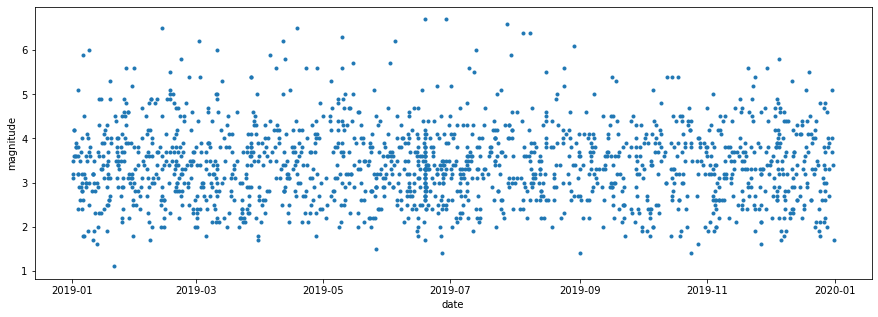

In [ ]:
# マグニチュードを日時の関数としてプロットしてみる
plt.figure(figsize=(15, 5))
plt.plot(dates, magnitudes, '.')
plt.xlabel('date')
plt.ylabel('magnitude')

## 2005年からのファイルを全てダウンロード

In [ ]:
dates, latitudes, longtitudes, magnitudes = [], [], [], []
for year in range(2005, 2020):
  url = 'https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/shindo/i{}.zip'.format(year)
  os.system('wget ' + url)  # download the file into i2019.zip

  # ダウンロードしたZipファイルを展開する
  with zipfile.ZipFile('i{}.zip'.format(year), 'r') as zip_ref:
    zip_ref.extract('i{}.dat'.format(year))

  dates1, latitudes1, longtitudes1, magnitudes1 = read_earthquake_data('i{}.dat'.format(year))
  
  # リストを結合する
  dates = dates + dates1
  latitudes = latitudes + latitudes1
  longtitudes = longtitudes + longtitudes1
  magnitudes = magnitudes + magnitudes1

Text(0, 0.5, 'magnitude')

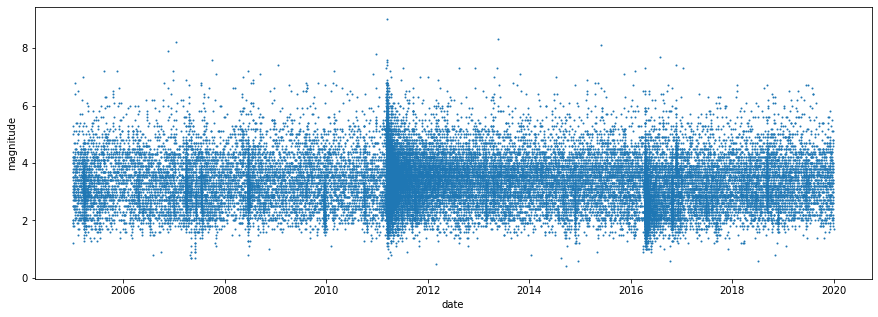

In [ ]:
# マグニチュードを日時の関数としてプロットしてみる
plt.figure(figsize=(15, 5))
plt.plot(dates, magnitudes, '.', markersize=2)
plt.xlabel('date')
plt.ylabel('magnitude')

## マグニチュードと頻度の関係をプロットする

Text(0, 0.5, 'frequency')

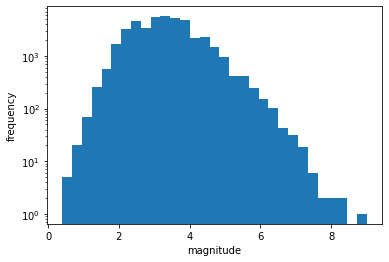

In [ ]:
plt.hist(magnitudes, bins=31)
plt.yscale('log')
plt.xlabel('magnitude')
plt.ylabel('frequency')

## 地震発生位置をプロットする

地図をプロットできるパッケージ folium を使う

参考  
https://newtechnologylifestyle.net/python_gpsprot/



In [ ]:
!pip install folium

In [ ]:
import folium

In [ ]:
map = folium.Map(location=[latitudes[0], longtitudes[0]], zoom_start=4)
# 最初の100個の地震をプロットする
for i in range(100):
  folium.Marker(location=[latitudes[i], longtitudes[i]]).add_to(map)

In [ ]:
map

## 課題（提出不要）

+ 各地方ごとの地震の頻度を比べる  
  九州・四国・中国・近畿・中部・関東・東北・北海道など

+ 地震の頻度は、規模 M に対して $\rho(M) \propto M^{-\alpha}$ というふうにべき乗分布で表されることが知られている。ここでマグニチュード$m$は $m = \log_{10} M + C$  ($C$は定数)として表される。べき指数 $α$ を上記のデータから求めてみよ。